# Задача восстановления регрессии
на примере определения числа багов

Датасет описывает некоторую зависимость числа bugs от значений repository_name, commit_hash, commit_date, commit_author, commit_message. Hеобходимо выявить данную зависимость

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_path = 'C:\\Users\\Эдуард Челышев\\Downloads\\Telegram Desktop\\АВСОФТ_тест_ML_приложение.csv'
dataset = pd.read_csv(file_path)

In [3]:
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1


# Подготовка данных

## Проверим пропуски

In [4]:
dataset.isna().sum()

repository_name    0
commit_hash        0
commit_date        0
commit_author      0
commit_message     0
bugs               0
dtype: int64

Пропусков не обнаружено

## Изучение данных

In [5]:
dataset.commit_author.unique()

array(['Victor', 'Peggy', 'Wendy', 'Trudy', 'Mallory', 'Eve', 'Dabe',
       'Carol', 'Bob', 'Alice'], dtype=object)

In [6]:
dataset.repository_name.unique()

array(['mlm', 'standard', 'agent', 'conductor', 'dockers', 'sensor'],
      dtype=object)

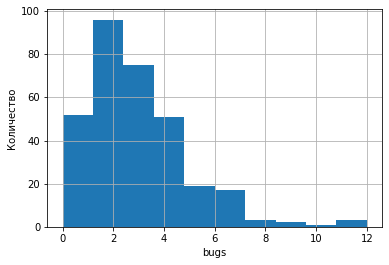

In [7]:
dataset['bugs'].hist()
plt.xlabel('bugs')
plt.ylabel('Количество')
plt.show()

<AxesSubplot:>

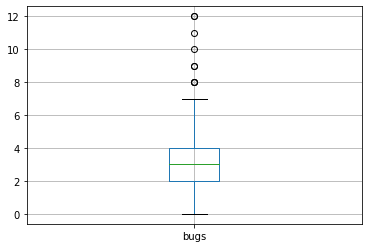

In [8]:
dataset.boxplot('bugs')

In [9]:
dataset[dataset.bugs >7]['bugs'].count()/len(dataset)

0.02821316614420063

Исключим объекты с числом багов больше 7

In [10]:
dataset=dataset.drop(dataset[dataset.bugs>7].index, axis=0)

In [11]:
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1


## Гипотезы о зависимостях и о feature engineering

Выдвигаю следующие предварительные гипотезы:
1) Целевой признак коррелирует с признаком 'commit_author'.

2) Целевой признак зависит от времени суток, когда был совершён коммит.

3) Целевой признак может зависеть от дня недели, когда был совершён коммит.

4) Целевой признак может зависеть от имени репозитория.

5) Целевой признак зависит от длины commit_message

При этом рассматривать признак <b>commit_hash</b> не буду (хэш коммита - по сути его идентификатор. Он уникален и никоим образом на целевой признак влиять не может)

## Гипотеза 1. Автор коммита

In [12]:
# число коммитов, совершенных разработчиками
commits = dataset.groupby(dataset.commit_author).commit_hash.count()
commits

commit_author
Alice        2
Bob          2
Carol        4
Dabe        42
Eve          9
Mallory     66
Peggy        2
Trudy        9
Victor     126
Wendy       48
Name: commit_hash, dtype: int64

In [13]:
# число багов, совершенных разработчиками
bugs = dataset.groupby(dataset.commit_author).sum()
bugs

,bugs
commit_author,
Alice,1
Bob,5
Carol,6
Dabe,101
Eve,32
Mallory,205
Peggy,7
Trudy,19
Victor,385


Заметно, что разработчики заметно отличаются друг от друга как по числу коммитов, так и по числу багов. Поэтому введен новый признак - среднее значение багов на разработчика

In [14]:
author_means = dataset.groupby(dataset.commit_author)['bugs'].mean()
dataset['mean_per_author'] = dataset.commit_author.map(author_means)
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,mean_per_author
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4,3.055556
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3,3.055556
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4,3.055556
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3,3.055556
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7,3.055556
...,...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1,2.404762
315,sensor,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2,2.404762
316,sensor,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3,2.404762
317,sensor,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1,2.404762


Проверим корреляцию:

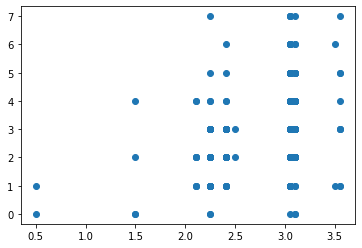

In [15]:
plt.scatter(dataset.mean_per_author, dataset.bugs)

In [16]:
dataset.corr()

,bugs,mean_per_author
bugs,1.000000,0.309698
mean_per_author,0.309698,1.000000


Заметна некоторая зависимость: чем больше значение mean_per_author, тем больше багов может допустить разработчик

## Гипотезы 2 и 3. Дата и время

In [17]:
# преобразование строки к типу дата-время
dataset.commit_date = pd.to_datetime(dataset['commit_date'],
                                     format='%Y-%m-%dT%H:%M:%S')

In [18]:
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,mean_per_author
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,3.055556
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,3.055556
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,3.055556
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,3.055556
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,3.055556
...,...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23 12:54:35,Dabe,setting hostname,1,2.404762
315,sensor,a3f5b753,2020-03-23 12:30:52,Dabe,heralding default dockerfile,2,2.404762
316,sensor,e8155942,2020-03-23 11:27:40,Dabe,unnesserity /data path permissions setting,3,2.404762
317,sensor,e748af51,2020-03-23 11:20:50,Dabe,added trapconductor,1,2.404762


In [19]:
print(dataset.commit_date.min(), dataset.commit_date.max(), sep=' --- ')

2020-03-08 14:26:16 --- 2020-06-12 14:26:12


Представлены данные за месяца с марта по июнь одного года. То есть использовать год и месяц в качестве признаков нельзя

In [20]:
# рассмотрим день недели как признак
dataset['day_of_week'] = dataset.commit_date.dt.day_of_week
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,mean_per_author,day_of_week
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,3.055556,4
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,3.055556,4
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,3.055556,3
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,3.055556,3
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,3.055556,3
...,...,...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23 12:54:35,Dabe,setting hostname,1,2.404762,0
315,sensor,a3f5b753,2020-03-23 12:30:52,Dabe,heralding default dockerfile,2,2.404762,0
316,sensor,e8155942,2020-03-23 11:27:40,Dabe,unnesserity /data path permissions setting,3,2.404762,0
317,sensor,e748af51,2020-03-23 11:20:50,Dabe,added trapconductor,1,2.404762,0


In [21]:
print(dataset.day_of_week.min(), dataset.day_of_week.max())

0 6


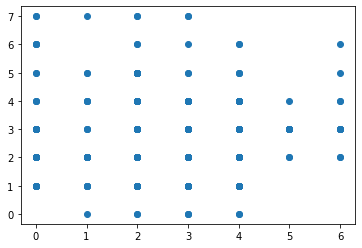

In [22]:
plt.scatter(dataset.day_of_week, dataset.bugs)

День недели - категориальный признак. Заменим номера дней недели на число, равное среднему числу багов на коммит в данный день недели

In [23]:
day_means = dataset.groupby(dataset.day_of_week)['bugs'].mean()
dataset['bugs_per_day'] = dataset.day_of_week.map(day_means)
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,mean_per_author,day_of_week,bugs_per_day
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,3.055556,4,2.573034
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,3.055556,4,2.573034
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,3.055556,3,2.750000
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,3.055556,3,2.750000
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,3.055556,3,2.750000
...,...,...,...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23 12:54:35,Dabe,setting hostname,1,2.404762,0,2.951220
315,sensor,a3f5b753,2020-03-23 12:30:52,Dabe,heralding default dockerfile,2,2.404762,0,2.951220
316,sensor,e8155942,2020-03-23 11:27:40,Dabe,unnesserity /data path permissions setting,3,2.404762,0,2.951220
317,sensor,e748af51,2020-03-23 11:20:50,Dabe,added trapconductor,1,2.404762,0,2.951220


In [24]:
dataset.corr()

,bugs,mean_per_author,day_of_week,bugs_per_day
bugs,1.000000,0.309698,-0.025950,0.146793
mean_per_author,0.309698,1.000000,-0.102407,0.093127
day_of_week,-0.025950,-0.102407,1.000000,-0.176782
bugs_per_day,0.146793,0.093127,-0.176782,1.000000


Для работы с временем будем использовать функцию sin(x) в радианах, так как 23:59 и 0:00 - по сути одно и то же время.
Кроме того, исходить будем из того, что нет необходимости учета секунд, учитывать будем только минуты

In [25]:
total_min = 24 * 60

In [26]:
dataset['sin_time'] = np.sin(
    2 * np.pi *
    (dataset.commit_date.dt.hour * 60 + dataset.commit_date.dt.minute) /
    total_min)
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,mean_per_author,day_of_week,bugs_per_day,sin_time
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,3.055556,4,2.573034,-0.594823
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,3.055556,4,2.573034,0.030539
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,3.055556,3,2.750000,-0.763232
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,3.055556,3,2.750000,0.333807
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,3.055556,3,2.750000,0.625923
...,...,...,...,...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23 12:54:35,Dabe,setting hostname,1,2.404762,0,2.951220,-0.233445
315,sensor,a3f5b753,2020-03-23 12:30:52,Dabe,heralding default dockerfile,2,2.404762,0,2.951220,-0.130526
316,sensor,e8155942,2020-03-23 11:27:40,Dabe,unnesserity /data path permissions setting,3,2.404762,0,2.951220,0.143493
317,sensor,e748af51,2020-03-23 11:20:50,Dabe,added trapconductor,1,2.404762,0,2.951220,0.173648


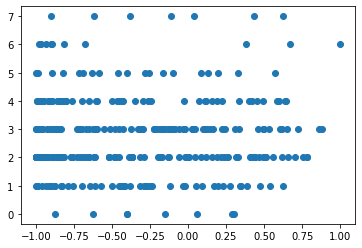

In [27]:
plt.scatter(dataset.sin_time, dataset.bugs)

In [28]:
dataset.corr()

,bugs,mean_per_author,day_of_week,bugs_per_day,sin_time
bugs,1.000000,0.309698,-0.025950,0.146793,0.002420
mean_per_author,0.309698,1.000000,-0.102407,0.093127,-0.030599
day_of_week,-0.025950,-0.102407,1.000000,-0.176782,0.048797
bugs_per_day,0.146793,0.093127,-0.176782,1.000000,-0.082703
sin_time,0.002420,-0.030599,0.048797,-0.082703,1.000000


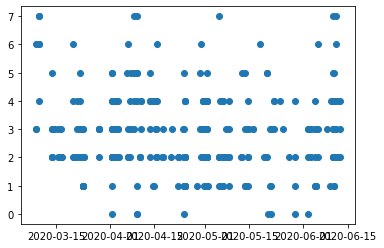

In [29]:
plt.scatter(dataset.commit_date, dataset.bugs)

Можно заключить, что, вопреки ожиданиям, зависимость от времени незначительна

## Гипотеза 4. Имя репозитория

In [30]:
rep_means = dataset.groupby(dataset.repository_name)['bugs'].mean()
print(rep_means)
dataset['bugs_per_rep'] = dataset.repository_name.map(rep_means)
dataset

repository_name
agent        2.928571
conductor    2.864865
dockers      2.526316
mlm          4.114286
sensor       2.284314
standard     2.931034
Name: bugs, dtype: float64


,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,mean_per_author,day_of_week,bugs_per_day,sin_time,bugs_per_rep
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,3.055556,4,2.573034,-0.594823,4.114286
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,3.055556,4,2.573034,0.030539,4.114286
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,3.055556,3,2.750000,-0.763232,4.114286
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,3.055556,3,2.750000,0.333807,4.114286
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,3.055556,3,2.750000,0.625923,4.114286
...,...,...,...,...,...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23 12:54:35,Dabe,setting hostname,1,2.404762,0,2.951220,-0.233445,2.284314
315,sensor,a3f5b753,2020-03-23 12:30:52,Dabe,heralding default dockerfile,2,2.404762,0,2.951220,-0.130526,2.284314
316,sensor,e8155942,2020-03-23 11:27:40,Dabe,unnesserity /data path permissions setting,3,2.404762,0,2.951220,0.143493,2.284314
317,sensor,e748af51,2020-03-23 11:20:50,Dabe,added trapconductor,1,2.404762,0,2.951220,0.173648,2.284314


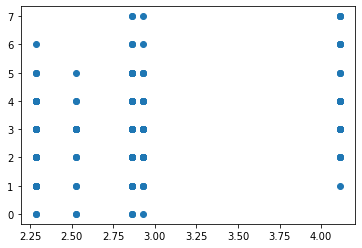

In [31]:
plt.scatter(dataset.bugs_per_rep, dataset.bugs)

In [32]:
dataset.corr()

,bugs,mean_per_author,day_of_week,bugs_per_day,sin_time,bugs_per_rep
bugs,1.000000,0.309698,-0.025950,0.146793,0.002420,0.369403
mean_per_author,0.309698,1.000000,-0.102407,0.093127,-0.030599,0.114783
day_of_week,-0.025950,-0.102407,1.000000,-0.176782,0.048797,0.050637
bugs_per_day,0.146793,0.093127,-0.176782,1.000000,-0.082703,0.169394
sin_time,0.002420,-0.030599,0.048797,-0.082703,1.000000,-0.118043
bugs_per_rep,0.369403,0.114783,0.050637,0.169394,-0.118043,1.000000


## Гипотеза 5. Длина сообщений

In [33]:
# вычислим максимальную длину строки
max_len = dataset.commit_message.apply(len).max()
print(max_len)

82


In [34]:
# функция выделения относительной длины сообщения
def from_len(str):
    return len(str) / max_len

In [35]:
dataset['from_len'] = dataset.commit_message.apply(from_len)
dataset

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs,mean_per_author,day_of_week,bugs_per_day,sin_time,bugs_per_rep,from_len
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4,3.055556,4,2.573034,-0.594823,4.114286,0.463415
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3,3.055556,4,2.573034,0.030539,4.114286,0.304878
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4,3.055556,3,2.750000,-0.763232,4.114286,0.451220
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3,3.055556,3,2.750000,0.333807,4.114286,0.341463
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7,3.055556,3,2.750000,0.625923,4.114286,0.682927
...,...,...,...,...,...,...,...,...,...,...,...,...
314,sensor,5b1ecbcd,2020-03-23 12:54:35,Dabe,setting hostname,1,2.404762,0,2.951220,-0.233445,2.284314,0.195122
315,sensor,a3f5b753,2020-03-23 12:30:52,Dabe,heralding default dockerfile,2,2.404762,0,2.951220,-0.130526,2.284314,0.341463
316,sensor,e8155942,2020-03-23 11:27:40,Dabe,unnesserity /data path permissions setting,3,2.404762,0,2.951220,0.143493,2.284314,0.512195
317,sensor,e748af51,2020-03-23 11:20:50,Dabe,added trapconductor,1,2.404762,0,2.951220,0.173648,2.284314,0.231707


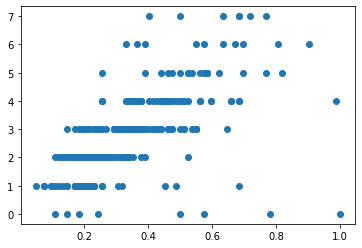

In [36]:
plt.scatter(dataset.from_len, dataset.bugs)

In [37]:
dataset.corr()

,bugs,mean_per_author,day_of_week,bugs_per_day,sin_time,bugs_per_rep,from_len
bugs,1.000000,0.309698,-0.025950,0.146793,0.002420,0.369403,0.650079
mean_per_author,0.309698,1.000000,-0.102407,0.093127,-0.030599,0.114783,0.151938
day_of_week,-0.025950,-0.102407,1.000000,-0.176782,0.048797,0.050637,-0.039623
bugs_per_day,0.146793,0.093127,-0.176782,1.000000,-0.082703,0.169394,0.015239
sin_time,0.002420,-0.030599,0.048797,-0.082703,1.000000,-0.118043,0.039454
bugs_per_rep,0.369403,0.114783,0.050637,0.169394,-0.118043,1.000000,0.039495
from_len,0.650079,0.151938,-0.039623,0.015239,0.039454,0.039495,1.000000


Видно, что зависимость достаточно сильная

## Формирование обучающей и тестовой выборок

In [38]:
df = pd.concat([
    dataset.mean_per_author, dataset.bugs_per_day, dataset.bugs_per_rep,
    dataset.from_len, dataset.bugs
],
               axis=1)
df

,mean_per_author,bugs_per_day,bugs_per_rep,from_len,bugs
0,3.055556,2.573034,4.114286,0.463415,4
1,3.055556,2.573034,4.114286,0.304878,3
2,3.055556,2.750000,4.114286,0.451220,4
3,3.055556,2.750000,4.114286,0.341463,3
4,3.055556,2.750000,4.114286,0.682927,7
...,...,...,...,...,...
314,2.404762,2.951220,2.284314,0.195122,1
315,2.404762,2.951220,2.284314,0.341463,2
316,2.404762,2.951220,2.284314,0.512195,3
317,2.404762,2.951220,2.284314,0.231707,1


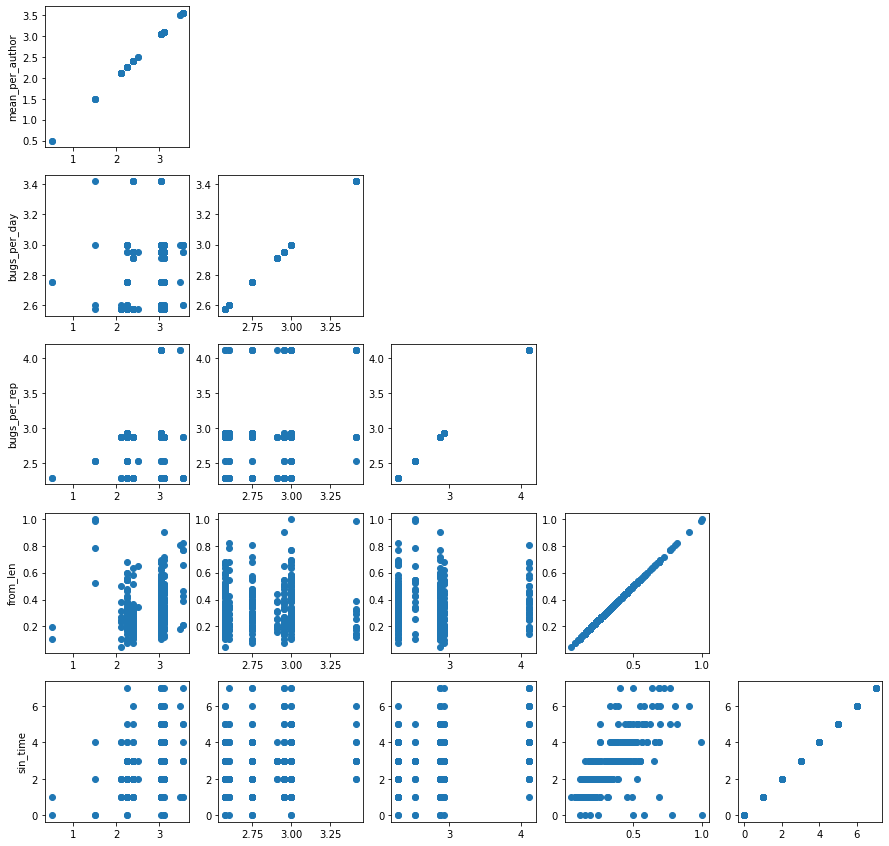

In [39]:
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
features=['mean_per_author', 'bugs_per_day', 'bugs_per_rep', 'from_len', 'sin_time', 'bugs']
for i in range(5):
    for j in range(5):
        ax[i, j].scatter(df.iloc[:, j], df.iloc[:, i])
        #ax[i, j].set_xticks(())
        #ax[i, j].set_yticks(())
        if i == 5:
            ax[i, j].set_xlabel(features[j])
        if j == 0:
            ax[i, j].set_ylabel(features[i])
        if i<j:
            ax[i,j].set_visible(False)

In [40]:
# сохранение датасета в файл
df.to_csv('prepared_dataset2.csv', index=False)

## Построение регрессионных моделей

In [41]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

In [42]:
Ridge_reg = Ridge()
Lasso_reg=Lasso()
Forest_reg=RandomForestRegressor()
SVR_reg=SVR()

In [43]:
y = df.filter(['bugs'])
y=np.ravel(y)
y

array([4, 3, 4, 3, 7, 6, 4, 4, 2, 5, 2, 1, 5, 7, 4, 2, 4, 6, 4, 2, 3, 2,
       3, 3, 3, 5, 4, 6, 7, 6, 4, 7, 3, 6, 3, 1, 0, 3, 6, 3, 3, 3, 3, 2,
       3, 1, 1, 5, 5, 2, 3, 4, 4, 2, 7, 2, 2, 2, 3, 2, 4, 4, 3, 2, 1, 3,
       2, 3, 2, 3, 4, 4, 3, 5, 5, 2, 2, 2, 2, 2, 2, 3, 1, 2, 1, 3, 3, 0,
       4, 1, 4, 4, 2, 2, 1, 4, 2, 4, 3, 2, 5, 2, 4, 2, 4, 4, 5, 4, 4, 1,
       2, 2, 2, 1, 5, 3, 2, 3, 2, 4, 6, 2, 4, 2, 4, 1, 4, 4, 4, 2, 2, 7,
       4, 5, 0, 5, 5, 7, 3, 4, 2, 6, 3, 5, 2, 3, 3, 2, 4, 2, 2, 2, 3, 0,
       2, 2, 3, 2, 2, 2, 3, 4, 3, 2, 2, 2, 2, 2, 6, 4, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 5, 2, 3, 3, 3, 0, 3, 2, 3, 4, 3,
       0, 3, 2, 1, 2, 3, 4, 1, 3, 5, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1,
       2, 2, 3, 2, 4, 2, 1, 1, 4, 2, 1, 1, 1, 1, 4, 2, 4, 3, 3, 3, 3, 3,
       2, 2, 6, 3, 3, 1, 1, 4, 1, 1, 2, 2, 1, 0, 3, 1, 1, 2, 3, 2, 2, 1,
       2, 2, 3, 3, 3, 2, 4, 3, 2, 0, 1, 4, 3, 5, 2, 2, 3, 4, 2, 4, 4, 4,
       2, 3, 2, 5, 4, 5, 2, 4, 3, 1, 3, 3, 3, 3, 2,

In [44]:
X = df.drop(['bugs'], axis=1)
X

,mean_per_author,bugs_per_day,bugs_per_rep,from_len
0,3.055556,2.573034,4.114286,0.463415
1,3.055556,2.573034,4.114286,0.304878
2,3.055556,2.750000,4.114286,0.451220
3,3.055556,2.750000,4.114286,0.341463
4,3.055556,2.750000,4.114286,0.682927
...,...,...,...,...
314,2.404762,2.951220,2.284314,0.195122
315,2.404762,2.951220,2.284314,0.341463
316,2.404762,2.951220,2.284314,0.512195
317,2.404762,2.951220,2.284314,0.231707


In [45]:
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.83636364, 0.        , 1.        , 0.43589744],
       [0.83636364, 0.        , 1.        , 0.26923077],
       [0.83636364, 0.20976693, 1.        , 0.42307692],
       ...,
       [0.62337662, 0.4482824 , 0.        , 0.48717949],
       [0.62337662, 0.4482824 , 0.        , 0.19230769],
       [0.62337662, 0.4482824 , 0.        , 0.02564103]])

In [46]:
lin_params = {'alpha': np.logspace(-2, 1, 37)}
forest_params={'n_estimators':range(50,151,25),
              'max_depth':range(1,11),
              'max_features':range(1,5)}
svr_params={'C':np.logspace(-1, 1, 33), 
            'epsilon':np.logspace(-2, 1, 37)}

### Ridge

In [47]:
grid = GridSearchCV(Ridge_reg, lin_params, scoring = ['neg_mean_squared_error','neg_mean_absolute_error'], 
                    refit='neg_mean_absolute_error')
grid.fit(X, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 0.01      ,  0.01211528,  0.01467799,  0.01778279,  0.02154435,
        0.02610157,  0.03162278,  0.03831187,  0.04641589,  0.05623413,
        0.06812921,  0.08254042,  0.1       ,  0.12115277,  0.14677993,
        0.17782794,  0.21544347,  0.26101572,  0.31622777,  0.38311868,
        0.46415888,  0.56234133,  0.68129207,  0.82540419,  1.        ,
        1.21152766,  1.46779927,  1.77827941,  2.15443469,  2.61015722,
        3.16227766,  3.83118685,  4.64158883,  5.62341325,  6.81292069,
        8.25404185, 10.        ])},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [48]:
grid.best_params_

{'alpha': 1.467799267622069}

In [49]:
grid.best_score_

-0.7174012361925198

### Lasso

In [50]:
grid = GridSearchCV(Lasso_reg, lin_params, scoring = ['neg_mean_squared_error','neg_mean_absolute_error'], 
                    refit='neg_mean_absolute_error')
grid.fit(X, y)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([ 0.01      ,  0.01211528,  0.01467799,  0.01778279,  0.02154435,
        0.02610157,  0.03162278,  0.03831187,  0.04641589,  0.05623413,
        0.06812921,  0.08254042,  0.1       ,  0.12115277,  0.14677993,
        0.17782794,  0.21544347,  0.26101572,  0.31622777,  0.38311868,
        0.46415888,  0.56234133,  0.68129207,  0.82540419,  1.        ,
        1.21152766,  1.46779927,  1.77827941,  2.15443469,  2.61015722,
        3.16227766,  3.83118685,  4.64158883,  5.62341325,  6.81292069,
        8.25404185, 10.        ])},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [51]:
grid.best_params_

{'alpha': 0.01778279410038923}

In [52]:
grid.best_score_

-0.7105358538884913

### RandomForest

In [53]:
grid = GridSearchCV(Forest_reg, forest_params, scoring = ['neg_mean_squared_error','neg_mean_absolute_error'],
                    refit='neg_mean_absolute_error')
grid.fit(X, y)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 11), 'max_features': range(1, 5),
                         'n_estimators': range(50, 151, 25)},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [54]:
grid.best_params_

{'max_depth': 10, 'max_features': 1, 'n_estimators': 50}

In [55]:
grid.best_score_

-0.7032566443962878

### SVR

In [56]:
grid = GridSearchCV(SVR_reg, svr_params, scoring = ['neg_mean_squared_error','neg_mean_absolute_error'], 
                    refit='neg_mean_absolute_error')
grid.fit(X, y)

GridSearchCV(estimator=SVR(),
             param_grid={'C': array([ 0.1       ,  0.1154782 ,  0.13335214,  0.15399265,  0.17782794,
        0.2053525 ,  0.23713737,  0.27384196,  0.31622777,  0.36517413,
        0.4216965 ,  0.48696753,  0.56234133,  0.64938163,  0.74989421,
        0.86596432,  1.        ,  1.15478198,  1.33352143,  1.53992653,
        1.77827941,  2.05352503,  2.37137371,  2.73841963,  3.16227766,
        3.65174127,  4.21696503,  4.86967525,  5.623413...
        0.06812921,  0.08254042,  0.1       ,  0.12115277,  0.14677993,
        0.17782794,  0.21544347,  0.26101572,  0.31622777,  0.38311868,
        0.46415888,  0.56234133,  0.68129207,  0.82540419,  1.        ,
        1.21152766,  1.46779927,  1.77827941,  2.15443469,  2.61015722,
        3.16227766,  3.83118685,  4.64158883,  5.62341325,  6.81292069,
        8.25404185, 10.        ])},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [57]:
grid.best_params_

{'C': 1.7782794100389228, 'epsilon': 0.31622776601683794}

In [58]:
grid.best_score_

-0.7100994567991622

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=2)

In [60]:
Lasso_regressor=Lasso(alpha=0.017)
Lasso_regressor.fit(X_train,y_train)

Lasso(alpha=0.017)

In [61]:
Ridge_regressor=Ridge(alpha=1.46)
Ridge_regressor.fit(X_train, y_train)

Ridge(alpha=1.46)

In [62]:
Forest_regressor=RandomForestRegressor(max_depth=10, max_features=1, n_estimators=50)
Forest_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=1, n_estimators=50)

In [63]:
SVR_regressor=SVR(C=1.778, epsilon=0.316)
SVR_regressor.fit(X_train, y_train)

SVR(C=1.778, epsilon=0.316)

In [64]:
def print_metrics(y,y_pred):
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('Max', max_error(y_test, y_pred))
    pass

In [65]:
def estimate_model(model, y):
    print('До округления')
    y_pred=model.predict(X_test)
    markerline, stemlines, baseline=plt.stem(
        range(0, len(y_pred)), abs(y_pred-y_test), linefmt='blue',label='abs_error without round')
    markerline.set_markerfacecolor('blue')
    print_metrics(y,y_pred)
    print('После округления')
    y_pred=np.round(y_pred,decimals=0)
    print_metrics(y,y_pred)
    markerline, stemlines, baseline=plt.stem(
        range(0, len(y_pred)), abs(y_pred-y_test), linefmt='red',label='abs_error with round')
    markerline.set_markerfacecolor('red')
    plt.legend()
    pass

До округления
MSE 1.0174638774528928
MAE 0.6748983380914493
Max 4.128588042789765
После округления
MSE 1.0769230769230769
MAE 0.5897435897435898
Max 4.0


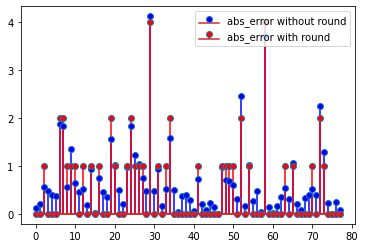

In [66]:
estimate_model(Lasso_regressor,y)

До округления
MSE 1.022313231018337
MAE 0.688287513284263
Max 3.757818742079549
После округления
MSE 1.2564102564102564
MAE 0.6923076923076923
Max 4.0


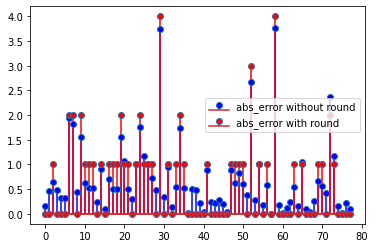

In [67]:
estimate_model(Ridge_regressor,y)

До округления
MSE 0.9949485606994535
MAE 0.6294370515524361
Max 4.442333333333334
После округления
MSE 1.0769230769230769
MAE 0.5897435897435898
Max 4.0


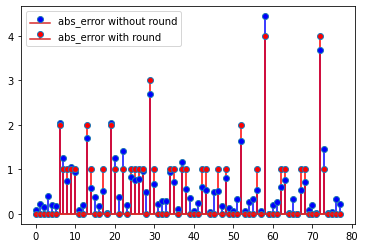

In [68]:
estimate_model(Forest_regressor,y)

До округления
MSE 0.7948751511347734
MAE 0.5974393655111455
Max 4.438243597888599
После округления
MSE 0.8205128205128205
MAE 0.5128205128205128
Max 4.0


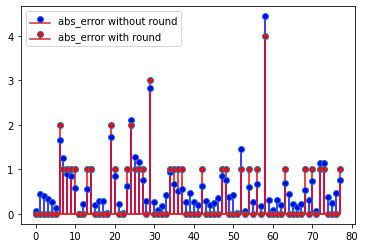

In [69]:
estimate_model(SVR_regressor,y)

## Значения метрик после округления

<table>
    <tr><th></th><th>Lasso</th><th>Ridge</th><th>Forest</th><th>SVR</th></tr>
    <tr><th>MSE</th><td>1.077</td><td>1.25</td><td>1.07</td><td>0.82</td></tr>
    <tr><th>MAE</th><td>0.58</td><td>0.69</td><td>0.58</td><td>0.51</td></tr>
    <tr><th>Max</th><td>4.0</td><td>4.0</td><td>4.0</td><td>4.0</td></tr>
    <tr><th></th><td></td><td></td><td></td><td></td></tr>
</table>

<b>Вывод:</b> Наилучшие значения метрик демонстрирует SVR (наименьшие значения среднеквадратичной ошибки и средней абсолютной ошибки на тестовой выборке). При этом все 4 модели показывают одинаковые значения максимальной абсолютной ошибки после округления